# LangGraph 챗봇 테스트 (V7)

## V7 주요 기능
- **RDB + RAG 통합 검색**: 상태/유형은 RDB 필터, 대상자/지역 세부는 RAG
- **검색 히스토리**: 이전 검색 복원 가능
- **추가 검색**: 기존 결과에 병합
- **비교 기능**: 여러 공고 비교
- **웹 검색**: Tavily 연동 (일반 질문)

## 의도 분류 (5가지)
- `search`: 공고 검색 (신규/추가/복원)
- `select`: 목록에서 선택
- `detail`: 상세 질문
- `compare`: 비교
- `chat`: 일반 대화/웹 검색

In [1]:
# 1. Django 환경 설정
import os
import sys
import django

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

project_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_path not in sys.path:
    sys.path.append(project_path)

os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'config.settings')
django.setup()

print(f"Django 환경 설정 완료: {project_path}")

Django 환경 설정 완료: /Users/kimjm/Desktop/ZIP-FIT-2/zf_django


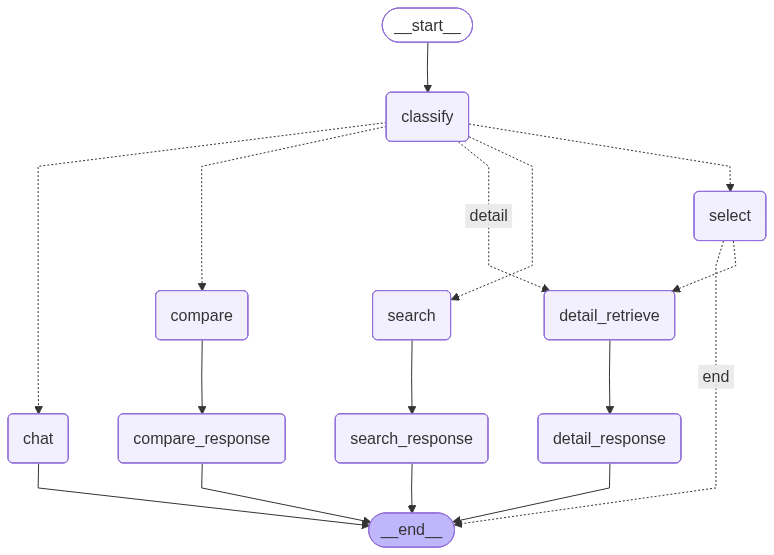

In [2]:
from chatbot.graph import create_chatbot_graph
create_chatbot_graph()

In [3]:
# 2. 모듈 임포트 (reload로 최신 코드 반영)
from importlib import reload
import chatbot.graph as graph_module
reload(graph_module)

from chatbot.graph import chat, get_chatbot, ChatbotConfig, Intent, TAVILY_AVAILABLE

# 싱글톤 초기화
graph_module._chatbot = None

print("="*60)
print("챗봇 모듈 로드 완료 (V7)")
print("="*60)
print(f"LLM 모델: {ChatbotConfig.LLM_MODEL}")
print(f"RAG TOP_K: {ChatbotConfig.RAG_TOP_K}")
print(f"Tavily 웹검색: {'활성화' if TAVILY_AVAILABLE else '비활성화 (API 키 필요)'}")
print()
print("[DB 메타데이터]")
print(f"  - 지역: {ChatbotConfig.get('regions')}")
print(f"  - 상태: {ChatbotConfig.get('statuses')}")
print(f"  - 유형: {ChatbotConfig.get('types')}")
print(f"  - 상세유형: {ChatbotConfig.get('dtl_types')}")

챗봇 모듈 로드 완료 (V7)
LLM 모델: gpt-4o-mini
RAG TOP_K: 15
Tavily 웹검색: 활성화

[DB 메타데이터]
  - 지역: ['대구광역시', '전라남도', '서울특별시 외', '충청북도', '전북특별자치도', '경상북도', '경기도', '대구광역시 외', '광주광역시 외', '전국', '인천광역시', '경상남도', '강원특별자치도']
  - 상태: ['공고중', '접수중']
  - 유형: ['임대']
  - 상세유형: ['전세임대', '행복주택', '매입임대', '영구임대', '공공임대', '국민임대']


In [4]:
# 3. DB 데이터 현황
from chatbot.models import AnncAll, DocChunks
from django.db.models import Count

print("="*60)
print("DB 데이터 현황")
print("="*60)

print(f"\n전체 공고: {AnncAll.objects.count()}건")
print(f"전체 청크: {DocChunks.objects.count()}건")

print("\n[공고 목록]")
for a in AnncAll.objects.all():
    chunk_cnt = DocChunks.objects.filter(annc_id=a.annc_id).count()
    print(f"  [{a.annc_id}] {a.annc_title[:45]}...")
    print(f"      {a.annc_region} | {a.annc_status} | {a.annc_dtl_type} | 청크:{chunk_cnt}개")

DB 데이터 현황

전체 공고: 31건
전체 청크: 3946건

[공고 목록]
  [1] 익산한스빌 국민임대주택 예비입주자 자격완화 모집공고...
      전북특별자치도 | 공고중 | 국민임대 | 청크:185개
  [3] 경북서부지역(구미시,김천시,대구광역시 군위군,의성군) 국민임대주택 예비자모집 공고...
      대구광역시 외 | 접수중 | 국민임대 | 청크:112개
  [5] (2025.12.05) 완주삼봉(A-1,A-3BL) 행복주택 입주자격완화 추가모집...
      전북특별자치도 | 공고중 | 행복주택 | 청크:147개
  [7] 정읍수성1 영구임대주택 예비입주자 모집 공고...
      전북특별자치도 | 공고중 | 영구임대 | 청크:169개
  [9] 2025년 신혼·신생아 전세임대 I 입주자 수시모집 공고...
      서울특별시 외 | 접수중 | 전세임대 | 청크:66개
  [11] 삼척도계/정선신동 임대주택 예비입주자 상시모집(소득완화)...
      강원특별자치도 | 공고중 | 국민임대 | 청크:157개
  [13] [정정공고]양주회천 A25BL 영구임대주택 입주자 모집공고...
      경기도 | 공고중 | 영구임대 | 청크:186개
  [15] 구미인의 50년 공공임대주택 예비입주자 모집 공고...
      경상북도 | 공고중 | 공공임대 | 청크:69개
  [17] 익산부송1, 익산동산단지 영구임대주택 입주자격완화 예비입주자 모집공고문...
      전북특별자치도 | 공고중 | 영구임대 | 청크:180개
  [19] [정정공고]양산사송 A-8BL 국민임대주택 입주자격완화·동호지정·상시모집 입주자 ...
      경상남도 | 공고중 | 국민임대 | 청크:169개
  [21] [정정공고]남원노암 영구임대주택 예비입주자 모집(모집공고일 : 2025.06.25...
      전북특별자치도 | 공고중 | 영구임대 | 청크:169개
  [23] 대구금호5 국민임대주택 입주자격 완화 동호지정 입주자 모집 공고 (선계약 후검증).

In [5]:
# 4. V7 핵심 기능 테스트
print("="*60)
print("V7 핵심 기능 테스트")
print("="*60)

session = {}

test_cases = [
    # 검색 테스트
    ("대상자 검색", "신혼부부 공고 추천해줘"),
    ("목록에서 선택", "1번 공고 알려줘"),
    ("상세 질문", "신청자격이 뭐야?"),
    ("추가 상세 질문", "면적 정보 알려줘"),
]

for name, question in test_cases:
    print(f"\n[{name}]")
    print(f"사용자: {question}")
    print("-"*50)
    
    result = chat(question, session)
    session = result.get('session_state', session)
    
    # 디버그 정보
    debug = result.get('debug_info', {})
    if 'intent_result' in debug:
        intent = debug['intent_result'].get('intent', '?')
        print(f"[의도: {intent}]")
    
    answer = result['answer']
    print(f"챗봇: {answer}")
    
    # 세션 상태
    prev_cnt = len(session.get('prev_anncs', []))
    selected = session.get('selected_annc')
    print(f"\n[세션] prev_anncs:{prev_cnt}개, selected:{selected['annc_title'][:30] if selected else 'None'}...")

V7 핵심 기능 테스트

[대상자 검색]
사용자: 신혼부부 공고 추천해줘
--------------------------------------------------
[의도: search]
챗봇: **추천 요약**: 1번 공고인 **'25년 12월 인천시(남동구) 행복주택 입주자격완화 예비입주자 모집**을 추천합니다. 이 공고는 신혼부부 및 예비신혼부부에게 적합한 조건을 갖추고 있습니다.

**간단한 설명**: 해당 공고는 혼인 기간이 10년 이내인 신혼부부와 입주 전 혼인 사실을 증명할 수 있는 예비신혼부부를 대상으로 하며, 입주 자격이 완화되어 있어 많은 분들이 지원할 수 있습니다. 마감일이 가까워 서둘러 신청하시는 것이 좋습니다.

다음 안내: "1번 공고 알려줘"로 상세 정보 확인해 보세요!

---
1. **'25년 12월 인천시(남동구) 행복주택 입주자격완화 예비입주자 모집**
   - 상태: 공고중 | 지역: 인천광역시 | D-6 | 마감: 2025.12.17
   - [공고 바로가기](https://apply.lh.or.kr/lhapply/apply/wt/wrtanc/selectWrtancInfo.do?mi=1026&panId=2015122300019132&ccrCnntSysDsCd=03&uppAisTpCd=06&aisTpCd=10)
2. **양주시, 동두천시 행복주택 상시모집[선착순동호지정, 입주자격완화, 선계약후검증]**
   - 상태: 공고중 | 지역: 경기도 | D-20 | 마감: 2025.12.31
   - [공고 바로가기](https://apply.lh.or.kr/lhapply/apply/wt/wrtanc/selectWrtancInfo.do?mi=1026&panId=2015122300018161&ccrCnntSysDsCd=03&uppAisTpCd=06&aisTpCd=10)
3. **[정정공고]포항블루밸리 행복주택 선착순 동호지정 상시모집(입주자격 완화, 통합공임 일반계층 추가, 선계약 후검증)**
   - 상태: 공고중 | 지역: 경상북

In [6]:
# # 5. 추가/복원/비교 기능 테스트
# print("="*60)
# print("추가/복원/비교 기능 테스트")
# print("="*60)

# session = {}

# test_flow = [
#     ("첫 검색", "접수중인 공고 알려줘"),
#     ("추가 검색", "공고중인 것도 보여줘"),
#     ("비교 요청", "1번이랑 2번 비교해줘"),
#     ("새 검색", "청년 공고 있어?"),
#     ("이전 검색 복원", "아까 접수중인 공고 다시 보여줘"),
# ]

# for name, question in test_flow:
#     print(f"\n[{name}]")
#     print(f"사용자: {question}")
#     print("-"*50)
    
#     result = chat(question, session)
#     session = result.get('session_state', session)
    
#     debug = result.get('debug_info', {})
#     intent_result = debug.get('intent_result', {})
#     intent = intent_result.get('intent', '?')
#     search_mode = intent_result.get('search_mode', '-')
#     print(f"[의도: {intent}, 모드: {search_mode}]")
    
#     answer = result['answer']
    
#     print(f"챗봇: {answer}")
    
#     prev_cnt = len(session.get('prev_anncs', []))
#     hist_cnt = len(session.get('search_history', []))
#     print(f"\n[세션] prev_anncs:{prev_cnt}개, search_history:{hist_cnt}개")

In [7]:
# # 6. 일반 대화 / 웹 검색 테스트
# print("="*60)
# print("일반 대화 / 웹 검색 테스트")
# print("="*60)

# chat_tests = [
#     # "안녕하세요",
#     # "행복주택이 뭐야?",
#     "2025년 청약 정책 변경사항 알려줘",
# ]

# for question in chat_tests:
#     print(f"\n사용자: {question}")
#     print("-"*50)
#     result = chat(question, {})
    
#     debug = result.get('debug_info', {})
#     intent_result = debug.get('intent_result', {})
#     needs_web = intent_result.get('needs_web_search', False)
#     print(f"[의도: {intent_result.get('intent', '?')}, 웹검색: {needs_web}]")
#     print(f"챗봇: {result['answer'][:400]}..." if len(result['answer']) > 400 else f"챗봇: {result['answer']}")

In [8]:
# # 7. 대화형 테스트
# print("="*60)
# print("대화형 챗봇 테스트 (V7)")
# print("="*60)
# print("명령어:")
# print("  'exit' - 종료")
# print("  'reset' - 대화 초기화")
# print("  'debug' - 세션 상태 출력")
# print("="*60)

# session_state = {}

# while True:
#     try:
#         question = input("\n사용자: ")
#     except EOFError:
#         break
    
#     if question.lower() == 'exit':
#         print("종료합니다.")
#         break
    
#     if question.lower() == 'reset':
#         session_state = {}
#         print("대화가 초기화되었습니다.")
#         continue
    
#     if question.lower() == 'debug':
#         print("\n[세션 상태]")
#         print(f"  chat_history: {len(session_state.get('chat_history', []))}개")
#         print(f"  search_history: {len(session_state.get('search_history', []))}개")
#         print(f"  prev_anncs: {len(session_state.get('prev_anncs', []))}개")
#         selected = session_state.get('selected_annc')
#         print(f"  selected_annc: {selected['annc_title'][:40] if selected else 'None'}")
#         if session_state.get('search_history'):
#             print("  [검색 기록]")
#             for h in session_state['search_history']:
#                 print(f"    - {h['query']}")
#         continue
    
#     if not question.strip():
#         continue
    
#     try:
#         result = chat(question, session_state)
#         session_state = result.get('session_state', session_state)
        
#         # 디버그 출력
#         debug = result.get('debug_info', {})
#         intent_result = debug.get('intent_result', {})
#         print(f"[의도: {intent_result.get('intent', '?')}]")
        
#         print(f"\n챗봇: {result['answer']}")
#     except Exception as e:
#         print(f"오류: {e}")
#         import traceback
#         traceback.print_exc()